In [ ]:
!pip install diffusers

# Importing Required Libaries

In [ ]:
import torch, logging
## disable warnings
logging.disable(logging.WARNING)
## Imaging  library
from PIL import Image
from torchvision import transforms as tfms
## Basic libraries
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from IPython.display import display
import shutil
import os
## For video display
from IPython.display import HTML
from base64 import b64encode
## Import the CLIP artifacts
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, LMSDiscreteScheduler
from IPython.display import display, clear_output

## Setting CPU/GPU device

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Helper functions

In [ ]:

def load_image(p):
    '''
    Function to load images from a defined path
    '''
    return Image.open(p).convert('RGB').resize((512,512))

def pil_to_latents(image):
    '''
    Function to convert image to latents
    '''
    init_image = tfms.ToTensor()(image).unsqueeze(0) * 2.0 - 1.0
    init_image = init_image.to(device="cuda", dtype=torch.float16)
    init_latent_dist = vae.encode(init_image).latent_dist.sample() * 0.18215
    return init_latent_dist

def latents_to_pil(latents):
    '''
    Function to convert latents to images
    '''
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

def text_enc(prompts, maxlen=None):
    '''
    A function to take a texual promt and convert it into embeddings
    '''
    if maxlen is None: maxlen = tokenizer.model_max_length
    inp = tokenizer(prompts, padding="max_length", max_length=maxlen, truncation=True, return_tensors="pt")
    return text_encoder(inp.input_ids.to("cuda"))[0].half()

In [ ]:
import torch
from PIL import Image
import io

def prompt_2_img(prompts, g=7.5, seed=100, steps=70, dim=512, save_int=True):
    """
    Diffusion process to convert prompt to image, modified to yield images for Streamlit.
    """

    bs = len(prompts)
    text = text_enc(prompts)
    uncond = text_enc([""] * bs, text.shape[1])
    emb = torch.cat([uncond, text])

    if seed:
        torch.manual_seed(seed)

    latents = torch.randn((bs, unet.in_channels, dim//8, dim//8))
    scheduler.set_timesteps(steps)
    latents = latents.to("cuda").half() * scheduler.init_noise_sigma

    for i, ts in enumerate(scheduler.timesteps):
        inp = scheduler.scale_model_input(torch.cat([latents] * 2), ts)
        with torch.no_grad():
            u, t = unet(inp, ts, encoder_hidden_states=emb).sample.chunk(2)
        pred = u + g*(t-u)
        latents = scheduler.step(pred, ts, latents).prev_sample

        if save_int and i % (steps // 10) == 0:  # Yield 10 images throughout the process
            image = latents_to_pil(latents)[0]
            buf = io.BytesIO()
            image.save(buf, format="JPEG")
            byte_im = buf.getvalue()
            yield byte_im  # Yield image in bytes format for Streamlit to display

    final_image = latents_to_pil(latents)
    final_buf = io.BytesIO()
    final_image[0].save(final_buf, format="JPEG")
    final_byte_im = final_buf.getvalue()
    yield final_byte_im  # Yield the final image

# Overview — The Diffusion Process

- The stable diffusion model takes the textual input and a seed.
- The textual input is then passed through the CLIP model to generate textual embedding of size 77x768 and the seed is used to generate Gaussian noise of size 4x64x64 which becomes the first latent image representation.
- Next, the U-Net iteratively denoises the random latent image representations while conditioning on the text embeddings.
- The output of the U-Net is predicted noise residual, which is then used to compute conditioned latents via a scheduler algorithm.
- This process of denoising and text conditioning is repeated N times (We will use 50) to retrieve a better latent image representation.
- Once this process is complete, the latent image representation (4x64x64) is decoded by the VAE decoder to retrieve the final output image (3x512x512).



In [ ]:
## Initiating the VAE
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae", torch_dtype=torch.float16).to("cuda")

## Initializing a scheduler and Setting number of sampling steps
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)
scheduler.set_timesteps(50)

## Initializing the U-Net model
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", torch_dtype=torch.float16).to("cuda")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

## Using OPENAI CLIP Model

##Using Finetuned CLIP Model

In [ ]:
tokenizer = CLIPTokenizer.from_pretrained("saiabhishek-itta/flick8-finetuned-clip", torch_dtype=torch.float16)
text_encoder = CLIPTextModel.from_pretrained("saiabhishek-itta/flick8-finetuned-clip", torch_dtype=torch.float16).to("cuda")

<ipython-input-6-a7455a8c3811>:18: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((bs, unet.in_channels, dim//8, dim//8))


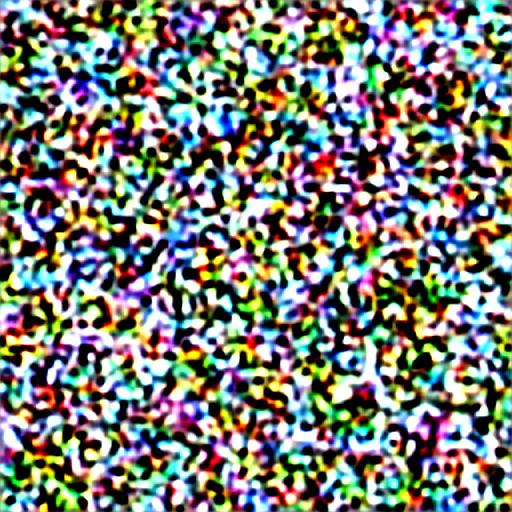

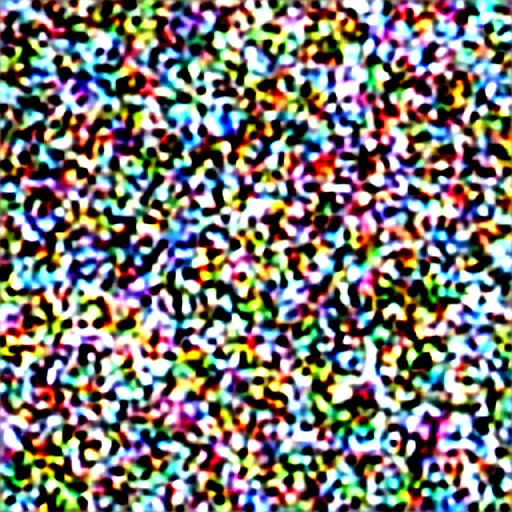

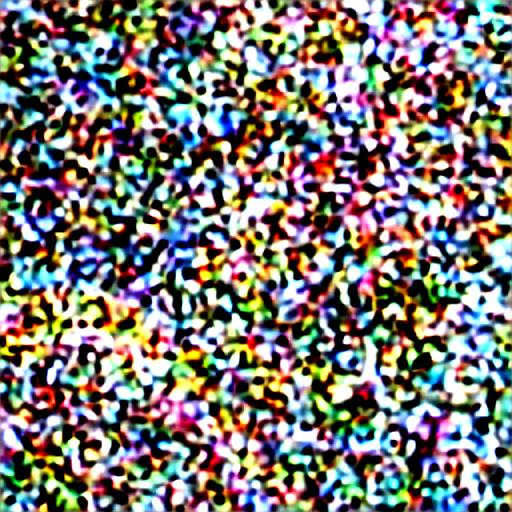

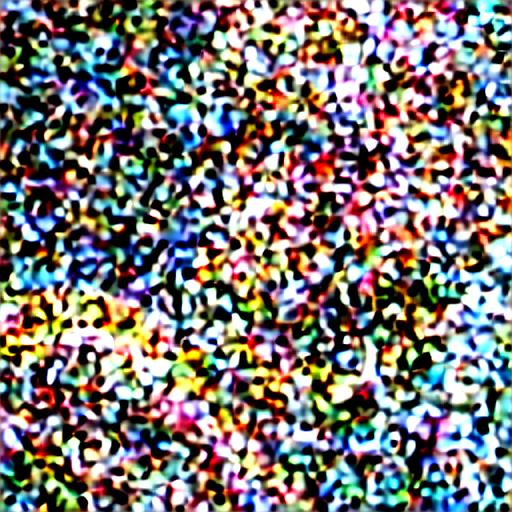

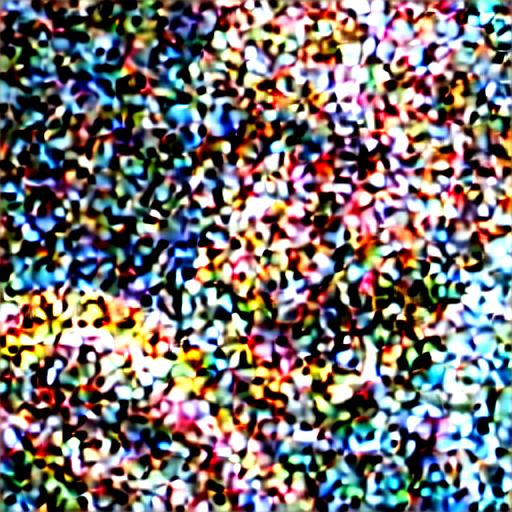

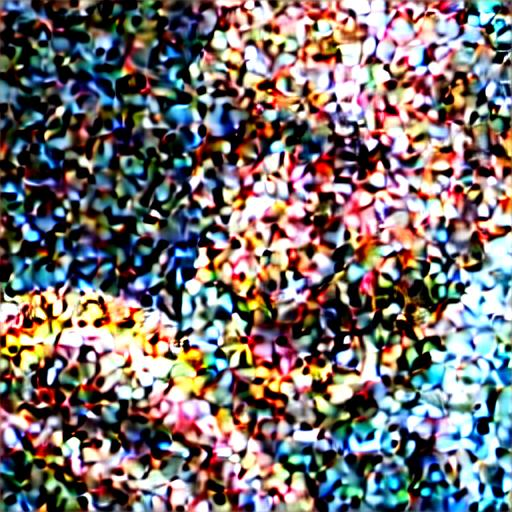

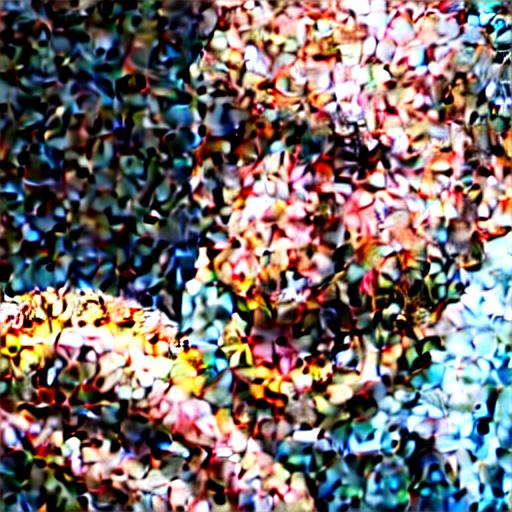

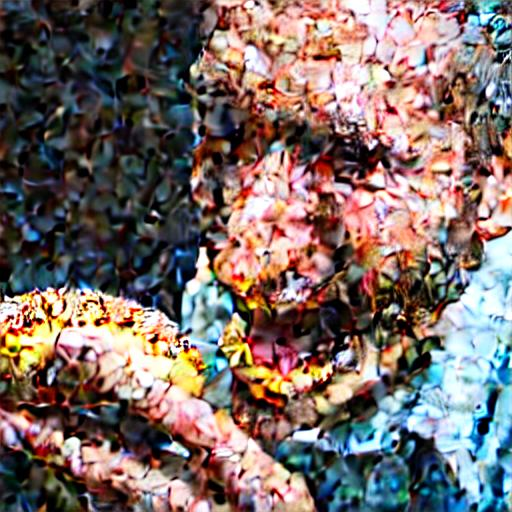

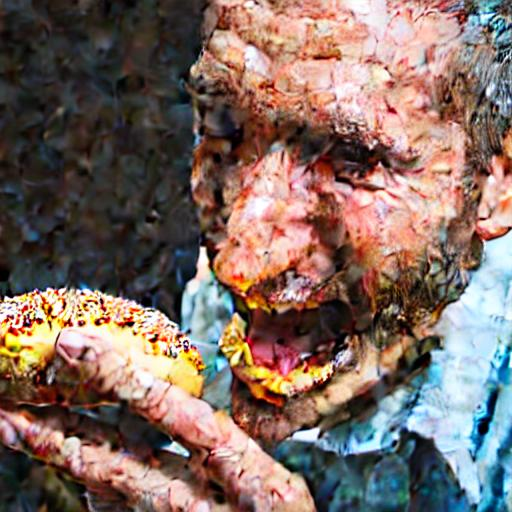

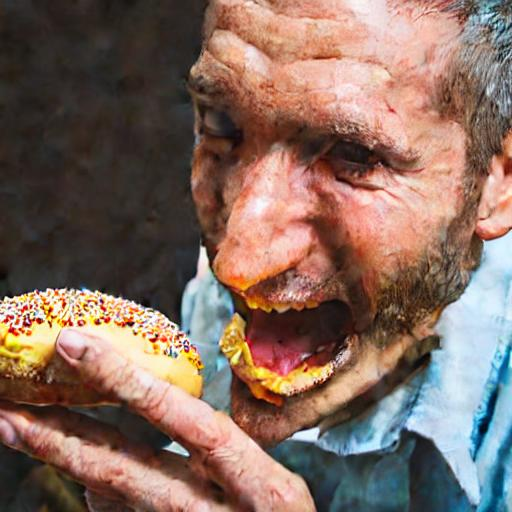

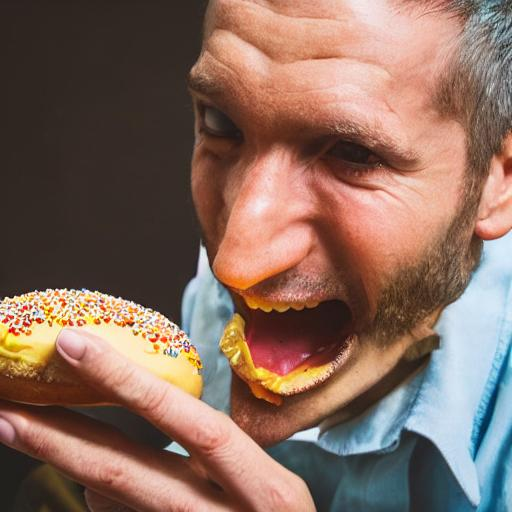

In [ ]:
import io
from PIL import Image
from IPython.display import display  # For Jupyter/IPython environments

# Function to convert byte data to PIL Image
def byte_to_image(byte_data):
    image = Image.open(io.BytesIO(byte_data))
    return image

byte_images = prompt_2_img(["man eating a doughnut"], save_int=True)

# Convert byte data to PIL Image and display
for byte_data in byte_images:
    img = byte_to_image(byte_data)
    display(img)

## Hosting on StreamLit

In [ ]:
!npm install localtunnel
!pip install streamlit

⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏
added 22 packages in 3s
⠏
⠏3 packages are looking for funding
⠏  run `npm fund` for details
⠏Collecting streamlit
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 98.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 104.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 8.4 MB/s eta 0:00:00


In [ ]:
%%writefile app.py

import streamlit as st
import io
from PIL import Image
import torch, logging
## disable warnings
logging.disable(logging.WARNING)
## Imaging  library
from torchvision import transforms as tfms
## Basic libraries
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import shutil
import os
## For video display
from IPython.display import HTML
from base64 import b64encode
## Import the CLIP artifacts
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, LMSDiscreteScheduler
from IPython.display import display, clear_output

# Initiating tokenizer and encoder.
tokenizer = CLIPTokenizer.from_pretrained("saiabhishek-itta/flick8-finetuned-clip", torch_dtype=torch.float16)
text_encoder = CLIPTextModel.from_pretrained("saiabhishek-itta/flick8-finetuned-clip", torch_dtype=torch.float16).to("cuda")


## Initiating the VAE
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae", torch_dtype=torch.float16).to("cuda")

## Initializing a scheduler and Setting number of sampling steps
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)
scheduler.set_timesteps(50)

## Initializing the U-Net model
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", torch_dtype=torch.float16).to("cuda")

## Helper functions
def load_image(p):
    return Image.open(p).convert('RGB').resize((512,512))

def pil_to_latents(image):
    init_image = tfms.ToTensor()(image).unsqueeze(0) * 2.0 - 1.0
    init_image = init_image.to(device="cuda", dtype=torch.float16)
    init_latent_dist = vae.encode(init_image).latent_dist.sample() * 0.18215
    return init_latent_dist

def latents_to_pil(latents):
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

def text_enc(prompts, maxlen=None):
    if maxlen is None: maxlen = tokenizer.model_max_length
    inp = tokenizer(prompts, padding="max_length", max_length=maxlen, truncation=True, return_tensors="pt")
    return text_encoder(inp.input_ids.to("cuda"))[0].half()


def prompt_2_img(prompts, g=7.5, seed=100, steps=70, dim=512, save_int=True):
    bs = len(prompts)
    text = text_enc(prompts)
    uncond = text_enc([""] * bs, text.shape[1])
    emb = torch.cat([uncond, text])
    if seed:
        torch.manual_seed(seed)
    latents = torch.randn((bs, unet.in_channels, dim//8, dim//8))
    scheduler.set_timesteps(steps)
    latents = latents.to("cuda").half() * scheduler.init_noise_sigma
    for i, ts in enumerate(scheduler.timesteps):
        inp = scheduler.scale_model_input(torch.cat([latents] * 2), ts)
        with torch.no_grad():
            u, t = unet(inp, ts, encoder_hidden_states=emb).sample.chunk(2)
        pred = u + g*(t-u)
        latents = scheduler.step(pred, ts, latents).prev_sample
        if save_int and i % (steps // 10) == 0:  # Yield 10 images throughout the process
            image = latents_to_pil(latents)[0]
            buf = io.BytesIO()
            image.save(buf, format="JPEG")
            byte_im = buf.getvalue()
            yield byte_im  # Yield image in bytes format for Streamlit to display
    final_image = latents_to_pil(latents)
    final_buf = io.BytesIO()
    final_image[0].save(final_buf, format="JPEG")
    final_byte_im = final_buf.getvalue()
    yield final_byte_im  # Yield the final image

def byte_to_image(byte_data):
    image = Image.open(io.BytesIO(byte_data))
    return image

# Streamlit app
def main():
    st.title("Diffusion Model Image Generator")

    # Input for the text prompt
    prompt = st.text_input("Enter your prompt:", "Create an image of a face of a young man")

    if st.button("Generate Image"):
        with st.spinner("Generating image..."):
            byte_images = prompt_2_img([prompt])
            for byte_data in byte_images:
                img = byte_to_image(byte_data)
                st.image(img, caption="Generated Image",use_container_width=True)

if __name__ == "__main__":
    main()


Overwriting app.py


In [ ]:
!streamlit run app.py & npx localtunnel --port 8501 & curl ipv4.icanhazip.com

34.87.95.125
⠙


  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.87.95.125:8501

your url is: https://angry-pots-create.loca.lt
2024-12-05 23:36:18.170257: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-05 23:36:18.195117: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-05 23:36:18.203323: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-05 23:36:19.667661: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/cont